# **MS1 calibration for monotonic behavior**

Fitting comressive, tensile strength (3D) and confined shear peak load (axisymmetric)

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [2]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl**2)[0,1,1,1,1])
        hoop_damage.append(1-(beta_ijkl**2)[0,2,2,2,2])
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage


In [3]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
    return omega_N_01, omega_N_11 

In [4]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11   

In [5]:
def get_sigma_N(m):
    
    sigma_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_N_01[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_radial[i] = max(sigma_11)
        
    return sigma_N_01, sigma_N_11, sigma_radial

## Unit element 3D

## Tensile test

In [6]:
CAxisymm = dict(
    E = 39226,
    nu = 0.18,
    Ad = 7000.0,
    eps_0 = 0.00001,
    K_N = 10000.,
    sigma_N_0 = 40.,
    gamma_N = 60000.,
    sigma_T_0 = 2.0,
    K_T = 500.0,
    gamma_T = 5000,
    S_T = 0.003,
    c_T = 10.,
    r_T = 13.,
    m_T = 0.1,
    p_T = 6.
)



In [7]:
size_x = 30
size_y = 4
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [8]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [9]:
w_max = 0.1

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [10]:
m.bc=bc1

m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.005
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass

In [11]:
U_tensile = np.average(m.hist.U_t[:, compression_dofs], axis=-1)
F_tensile = np.sum(m.hist.F_t[:, compression_dofs], axis=-1)

# G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
# G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
# print(G)
# print(G2)

In [12]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Compression test

In [23]:
size_x = 30
size_y = 4
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [24]:
w_max = -0.24

# Uniaxial tension/compression

bc_1 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, 0],
                  var='u', dims=[0,1,2], value=0.0)

bc_2 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, 0],
                  var='u', dims=[0,2], value=0.0)

bc_3 = BCSlice(slice=xmodel.mesh[:, :, :, 0, 0, -1],
                  var='u', dims=[0,1], value=0.0)

bc_4 = BCSlice(slice=xmodel.mesh[:, :, :, 0, -1, -1],
                  var='u', dims=[0], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]


In [25]:
bc1 = [bc_1, bc_2, bc_3, bc_4, compression_slice]  #+ slide #+ compression_force_first

In [26]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    'damage': Vis3DTensorField(var='omega_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.005
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
try:
    s.run()
except:
    # m_list_monotnonic.append(m)
    pass

In [27]:
U_compression = np.average(m.hist.U_t[:, compression_dofs], axis=-1)
F_compression = np.sum(m.hist.F_t[:, compression_dofs], axis=-1)

In [17]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['damage'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## shear 

In [18]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [19]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [20]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [21]:
m_list_monotnonic = []
# CAxisymm['m_T'] = 0.15
# CAxisymm['p_T'] = 7
# m_inelastic = MS13D(**CAxisymm)
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([0,-5,-15,-30])

w_max = 0.1

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.1
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    

    
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    
#     slide_upper[0].value *= 1.5
#     slide_upper[-1].value *= 0.5
    
    
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.005
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    # s.run()
    try:
        s.run()
    except:
        # m_list_monotnonic.append(m)
        pass
    m_list_monotnonic.append(m)

141.98615557854708
162.00372769274986
191.58293317757932
224.2389985723909


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
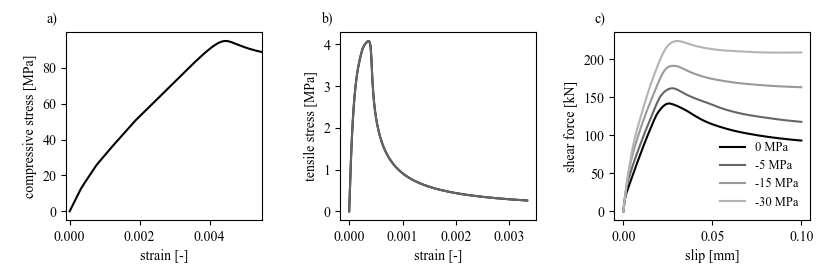

In [29]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"




fig, (ax1,ax2, ax3) = plt.subplots(1, 3,figsize=(21*cm, 7*cm))


ax1.plot(-U_compression/size_x, -F_compression/(size_y*size_z))
ax2.plot(U_tensile/size_x, F_tensile/(size_y*size_z))
ax1.set_ylabel('compressive stress [MPa]')
ax1.set_xlabel('strain [-]')
ax1.set_xlim(-0.0001,0.0055)

ax2.plot(U_tensile/size_x, F_tensile/(size_y*size_z))
ax2.set_ylabel('tensile stress [MPa]')
ax2.set_xlabel('strain [-]')

for m,compression in zip(m_list_monotnonic,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    radial_damage, hoop_damage, shear_damage = get_damage(m)
    print(max(abs(F_slide))/1000)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    
    ax3.plot(U_slide, F_slide/1000, label=str(compression)+' MPa')
    ax3.set_ylabel('shear force [kN]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
ax3.legend(loc=4, prop={'size': 9},frameon=False)
import string        
for n, ax in enumerate([ax1,ax2,ax3]):     
    ax.text(-0.1, 1.05, string.ascii_lowercase[n] + ')', transform=ax.transAxes, 
            size=10)  


left  = 0.08  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

# txt=str(CAxisymm)
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study02_calibration_normal\\pdf\\study02_monotonic_' + '.pdf')
fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study02_calibration_normal\\png\\study02_monotonic_'  + '.png')